# Decision tree for enumeration queries
## SparkSQL, basic features+POS features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [3]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [4]:
file_path = 'results/features_times_SPA_extra_full_enum_infos.csv'
df = pd.read_csv(file_path)
df.head()

bench                query orig/rewr(med)             orig(med)  \
0  STATS        001-014-full1           orig   0.03788018226623535   
1  STATS        001-014-full2           orig   0.03778505325317383   
2  STATS        001-014-full3           orig  0.038272857666015625   
3  STATS  001-014-augF1-full1           orig   0.03761172294616699   
4  STATS  001-014-augF1-full2           orig   0.03772568702697754   

             rewr(med)            stage0(med)           stage1(med)  \
0  0.08295345306396484  0.0010924339294433594   0.06107592582702637   
1  0.08245158195495605  0.0011365413665771484  0.060949087142944336   
2  0.08548593521118164  0.0011534690856933594   0.06313681602478027   
3  0.08422040939331055  0.0010836124420166016  0.061531782150268555   
4  0.08310413360595703   0.001062154769897461   0.06155538558959961   

            stage2(med)            stage3(med)  #relations  ...  \
0  0.019627809524536133     0.0008392333984375           3  ...   
1  0.019497156143188477  0.0008518695831298828           3  ...   
2   0.02027273178100586  0.0009043216705322266           3  ...   
3  0.019719362258911133  0.0008111000061035156           3  ...   
4  0.019450902938842773  0.0008108615875244141           3  ...   

   min(branching factors)  max(branching factors)  mean(branching factors)  \
0                       2                       2                      2.0   
1                       2                       2                      2.0   
2                       2                       2                      2.0   
3                       2                       2                      2.0   
4                       2                       2                      2.0   

   median(branching factors)  q25(branching factors)  q75(branching factors)  \
0                        2.0                     2.0                     2.0   
1                        2.0                     2.0                     2.0   
2                        2.0                     2.0                     2.0   
3                        2.0                     2.0                     2.0   
4                        2.0                     2.0                     2.0   

   balancedness factor                          container counts list  \
0                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
1                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
2                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
3                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   
4                  1.0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3]   

   branching factors list                                               text  
0                     [2]  SELECT u.Id, c.UserId FROM comments as c, vote...  
1                     [2]  SELECT v.UserId, u.Id FROM comments as c, vote...  
2                     [2]  SELECT u.Id, v.UserId FROM comments as c, vote...  
3                     [2]  SELECT u.Id, c.UserId FROM comments as c, vote...  
4                     [2]  SELECT v.UserId, u.Id FROM comments as c, vote...  

[5 rows x 43 columns]

In [5]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                     object
stage0(med)                   object
stage1(med)                   object
stage2(med)                   object
stage3(med)                   object
#relations                     int64
#conditions                    int64
#filters                       int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)               float64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
m

In [6]:
df["max(join rows)"] = df["max(join rows)"].astype(float)

#### Delete those examples, where both methods gave a timeout

In [7]:
df[df["orig/rewr(med)"] == "-"].shape

(231, 43)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [8]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(1510, 43)

In [9]:
df[df["orig(med)"] == "TO"].shape

(0, 43)

In [10]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [11]:
df[df["rewr(med)"] == "TO"].shape

(4, 43)

In [12]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [13]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [14]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [15]:
X = df.iloc[:, 9:39]
X.head()

#relations  #conditions  #filters  #joins  total cost  min(table rows)  \
0           3            7         5       2    11475.41                1   
1           3            7         5       2    11475.41                1   
2           3            7         5       2    11475.41                1   
3           3            7         5       2    11412.99                1   
4           3            7         5       2    11412.99                1   

   max(table rows)  mean(table rows)  q25(table rows)  median(table rows)  \
0           168966      56650.666667            493.0               985.0   
1           168966      56650.666667            493.0               985.0   
2           168966      56650.666667            493.0               985.0   
3           168966      56588.333333            399.5               798.0   
4           168966      56588.333333            399.5               798.0   

   ...  mean(container counts)  q25(container counts)  \
0  ...                1.133333                    1.0   
1  ...                1.133333                    1.0   
2  ...                1.133333                    1.0   
3  ...                1.133333                    1.0   
4  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       2                      2.0                        2.0   
2                       2                      2.0                        2.0   
3                       2                      2.0                        2.0   
4                       2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 30 columns]

#### Log-transformations

This basic features do not need log transformations.

In [16]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
#relations                   2.000000  1.100000e+01  9.000000e+00
#conditions                  2.000000  2.000000e+01  1.800000e+01
#filters                     0.000000  1.600000e+01  1.600000e+01
#joins                       1.000000  1.200000e+01  1.100000e+01
total cost                 197.890000  1.841784e+17  1.841784e+17
min(table rows)              1.000000  1.049866e+06  1.049865e+06
max(table rows)             19.000000  3.148317e+06  3.148298e+06
mean(table rows)             4.600000  1.609328e+06  1.609323e+06
q25(table rows)              1.000000  1.135242e+06  1.135242e+06
median(table rows)           1.000000  1.290166e+06  1.290165e+06
q75(table rows)              1.000000  1.896094e+06  1.896093e+06
min(join rows)               1.000000  4.802314e+10  4.802314e+10
max(join rows)               2.000000  1.227856e+19  1.227856e+19
mean(join rows)              1.200000  4.092854e+18  4.092854e+18
q25(join rows)               1.000000  4.957958e+10  4.957958e+10
median(join rows)            1.000000  5.113601e+10  5.113601e+10
q75(join rows)               1.000000  6.139280e+18  6.139280e+18
depth                        1.000000  3.000000e+00  2.000000e+00
min(container counts)        1.000000  1.000000e+00  0.000000e+00
max(container counts)        2.000000  5.000000e+00  3.000000e+00
mean(container counts)       1.047619  1.600000e+00  5.523810e-01
q25(container counts)        1.000000  1.000000e+00  0.000000e+00
median(container counts)     1.000000  1.000000e+00  0.000000e+00
q75(container counts)        1.000000  1.500000e+00  5.000000e-01
min(branching factors)       1.000000  6.000000e+00  5.000000e+00
max(branching factors)       1.000000  6.000000e+00  5.000000e+00
mean(branching factors)      1.000000  6.000000e+00  5.000000e+00
median(branching factors)    1.000000  6.000000e+00  5.000000e+00
q25(branching factors)       1.000000  6.000000e+00  5.000000e+00
q75(branching factors)       1.000000  6.000000e+00  5.000000e+00

In [17]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [18]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [19]:
y1.value_counts()

orig/rewr(med)
0    1259
1     251
Name: count, dtype: int64

In [20]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr      251
orig     1259
equal       -
dtype: object

In [21]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
orig    1259
rewr     251
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [22]:
stratification_df = df[df["bench"].isin(["STATS", "JOB", "HETIO"])]
lsqb_df = df[df["bench"] == "LSQB"]
snap_df = df[df["bench"] == "SNAP"]

stratification_X = X.loc[stratification_df.index]
lsqb_X = X.loc[lsqb_df.index]
snap_X = X.loc[snap_df.index]

stratification_y1 = y1.loc[stratification_df.index]
lsqb_y1 = y1.loc[lsqb_df.index]
snap_y1 = y1.loc[snap_df.index]

lsqb_choice = np.random.choice(3,3,replace=False)
snap_choice = np.random.choice(3,3,replace=False)

In [23]:
stratification_X_train, stratification_X_test, stratification_y1_train, stratification_y1_test = train_test_split(stratification_X, 
                        stratification_y1, test_size=0.2, stratify=stratification_df["bench"], random_state=40)
stratification_X_val, stratification_X_test, stratification_y1_val, stratification_y1_test = train_test_split(stratification_X_test, 
                        stratification_y1_test, test_size=0.5, stratify=stratification_df.loc[stratification_X_test.index]["bench"], random_state=40)
X_train = pd.concat([stratification_X_train, lsqb_X.iloc[lsqb_choice[0]].to_frame().T, snap_X.iloc[snap_choice[0]].to_frame().T], axis = 0)
X_val = pd.concat([stratification_X_val, lsqb_X.iloc[lsqb_choice[1]].to_frame().T, snap_X.iloc[snap_choice[1]].to_frame().T], axis = 0)
X_test = pd.concat([stratification_X_test, lsqb_X.iloc[lsqb_choice[2]].to_frame().T, snap_X.iloc[snap_choice[2]].to_frame().T], axis = 0)
y1_train = pd.concat([stratification_y1_train, pd.Series([lsqb_y1.iloc[lsqb_choice[0]]]), pd.Series([snap_y1.iloc[snap_choice[0]]])], axis = 0)
y1_val = pd.concat([stratification_y1_val, pd.Series([lsqb_y1.iloc[lsqb_choice[1]]]), pd.Series([snap_y1.iloc[snap_choice[1]]])], axis = 0)
y1_test = pd.concat([stratification_y1_test, pd.Series([lsqb_y1.iloc[lsqb_choice[2]]]), pd.Series([snap_y1.iloc[snap_choice[2]]])], axis = 0)

### Facts about the test set and runtime differences

In [24]:
y1_test.value_counts()

0    129
1     24
Name: count, dtype: int64

In [25]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [26]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [27]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_4271/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_4271/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_4271/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

cut   0.01  0.1    1   10  100  TO
rewr    11   46  125   69    0   0
orig    19  216  883  101   36   4

In [28]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [29]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_4271/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_4271/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1   1  10  100  TO
rewr     4    4  14   2    0   0
orig     2   25  89   9    3   1

### Train a decision tree and observe the results on the test set

In [30]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [31]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9738562091503268
0.9166666666666666
0.9166666666666666


array([[127,   2],
       [  2,  22]])

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [32]:
test_set = df.loc[y1_test.index]

In [33]:
test_set["decision"] = y1_pred_dec_tree

In [34]:
test_set["faster runtime true"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [35]:
test_set["faster runtime dec"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [36]:
summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["faster runtime dec"].sum(),
        test_set["faster runtime dec"].mean(),
        test_set["faster runtime dec"].min(),
        test_set["faster runtime dec"].max(),
        test_set["faster runtime dec"].median(),
        test_set["faster runtime dec"].std()
    ],
    "true": [
        test_set["faster runtime true"].sum(),
        test_set["faster runtime true"].mean(),
        test_set["faster runtime true"].min(),
        test_set["faster runtime true"].max(),
        test_set["faster runtime true"].median(),
        test_set["faster runtime true"].std()
    ]
}

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig        rewr         dec        true
sum     405.024128  599.797459  394.863421  394.211839
mean      2.647217    3.920245    2.580807    2.576548
median    0.001086    0.017550    0.001086    0.001086
std      58.665583  100.000000   58.665583   58.665583
min       0.257140    0.580857    0.257140    0.257140
max       8.330581   11.712020    8.220075    8.213063

#### Inspection of the misclassifications

In [37]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                    query orig/rewr(med)  \
1602           1           0  HETIO    4-03-CbGpPWpGaD-full3           orig   
1006           1           0  STATS            118-074-full1           orig   
1547           0           1  HETIO      3-03-CbGiGaD2-full2           rewr   
1615           0           1  HETIO  6-01-BPpGeA-augF1-full1           rewr   

      orig(med)  rewr(med)            stage0(med)          stage1(med)  \
1602  17.277348  17.839995    0.05237293243408203    1.096975564956665   
1006  11.329041  11.376386   0.024431228637695312  0.36089062690734863   
1547   0.509634   0.468110  0.0024623870849609375  0.12215757369995117   
1615   0.134420   0.134354  0.0016512870788574219  0.12198448181152344   

               stage2(med)  ... max(branching factors)  \
1602    0.1195366382598877  ...                      3   
1006   0.24343276023864746  ...                      5   
1547   0.05933094024658203  ...                      2   
1615  0.009682655334472656  ...                      2   

      mean(branching factors)  median(branching factors)  \
1602                      2.0                        2.0   
1006                      5.0                        5.0   
1547                      2.0                        2.0   
1615                      2.0                        2.0   

      q25(branching factors)  q75(branching factors)  balancedness factor  \
1602                     1.0                     3.0             0.625000   
1006                     5.0                     5.0             1.000000   
1547                     2.0                     2.0             1.000000   
1615                     2.0                     2.0             0.666667   

                                  container counts list  \
1602      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]   
1006  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1547                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]   
1615                              [1, 1, 1, 1, 1, 2, 3]   

      branching factors list  \
1602            [1, 1, 3, 3]   
1006                     [5]   
1547               [2, 2, 2]   
1615                  [2, 2]   

                                                   text  diff rewr-orig  
1602  SELECT part1.tid, a.tid FROM compound c, binds...        0.562647  
1006  SELECT b.UserId, p.OwnerUserId FROM comments a...        0.047345  
1547  SELECT a.tid, g2.nid FROM compound c1, binds b...       -0.041524  
1615  SELECT p.tid, e.tid FROM biological_process bp...       -0.000066  

[4 rows x 46 columns]

In [38]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


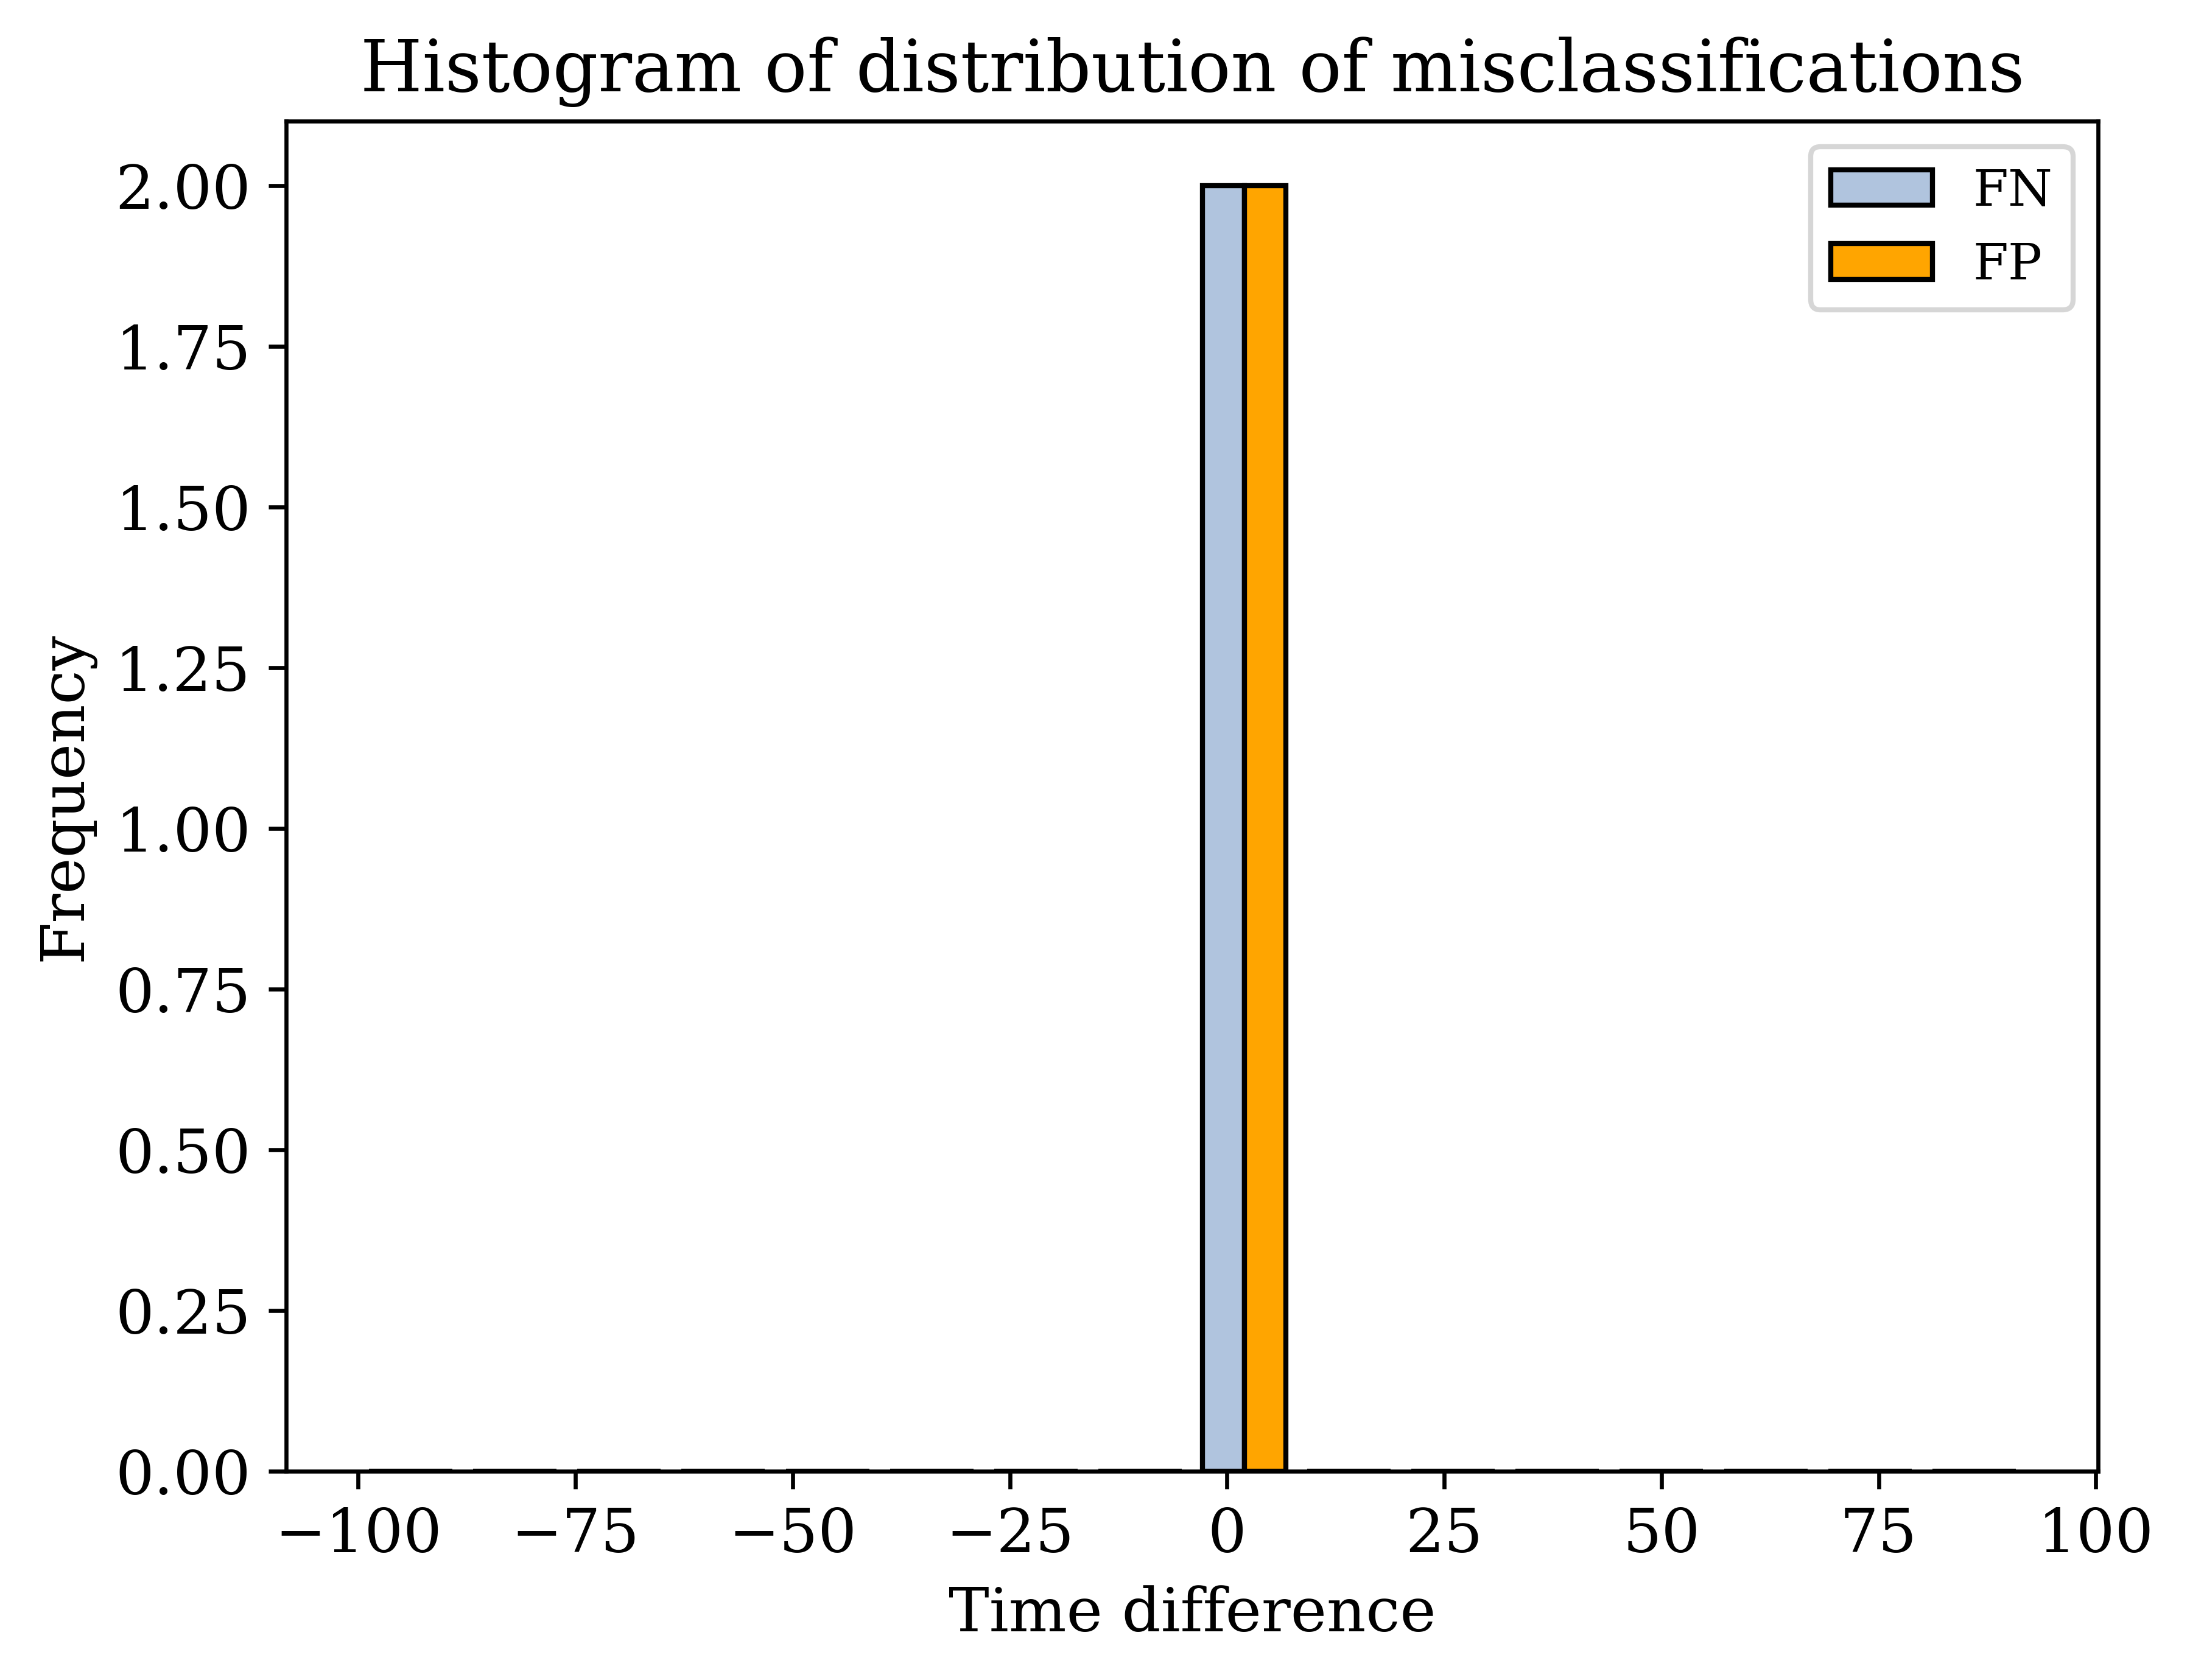

In [39]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/SPA_extra_enum_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [40]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_4271/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_4271/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_4271/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

cut  0.01  0.1  1  10  100  TO
FP      0    1  1   0    0   0
FN      1    1  0   0    0   0

#### Statistical tests

In [41]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [42]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                query orig/rewr(med)  \
419            0           0  STATS  049-118-augF1-full1           orig   
1566           0           0  HETIO   3-09-CrCrCtD-full3           orig   
1198           0           0  STATS  139-034-augF1-full1           orig   
372            0           0  STATS        044-145-full2           orig   
1468           0           0    JOB       5c-augF1-full1           orig   

      orig(med)  rewr(med)            stage0(med)           stage1(med)  \
419    0.419612   0.913221  0.0022270679473876953    0.2488856315612793   
1566   0.059813   0.147616   0.002629518508911133  0.046215057373046875   
1198   0.217567   0.322482  0.0017037391662597656   0.11929154396057129   
372    0.206505   0.613094   0.002681255340576172   0.23221135139465332   
1468   0.257140   1.419523   0.002050638198852539    1.4078130722045898   

               stage2(med)  ... mean(branching factors)  \
419     0.2248830795288086  ...                     3.0   
1566  0.028662443161010742  ...                     2.0   
1198   0.04177045822143555  ...                     3.0   
372    0.12110757827758789  ...                     5.0   
1468  0.007532596588134766  ...                     2.0   

      median(branching factors)  q25(branching factors)  \
419                         3.0                     3.0   
1566                        2.0                     1.5   
1198                        3.0                     3.0   
372                         5.0                     5.0   
1468                        2.0                     2.0   

      q75(branching factors)  balancedness factor  \
419                      3.0             1.000000   
1566                     2.5             0.666667   
1198                     3.0             1.000000   
372                      5.0             1.000000   
1468                     2.0             0.666667   

                                  container counts list  \
419   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1566                  [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3]   
1198  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
372   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1468  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

      branching factors list  \
419                      [3]   
1566               [1, 2, 3]   
1198                     [3]   
372                      [5]   
1468                  [2, 2]   

                                                   text  diff rewr-orig  \
419   SELECT v.PostId, u.Id FROM postHistory as ph, ...        0.493608   
1566  SELECT r2.sid, t.tid FROM compound c1, resembl...        0.087804   
1198  SELECT c.UserId, b.UserId FROM comments as c, ...        0.104914   
372   SELECT p.OwnerUserId, p.Id FROM comments as c,...        0.406590   
1468  SELECT mc.company_type_id, ct.id FROM company_...        1.162382   

      pred(med)  
419    0.419612  
1566   0.059813  
1198   0.217567  
372    0.206505  
1468   0.257140  

[5 rows x 47 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

In [43]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 24.0
P-value: 0.00031821718031506727


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [44]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 3.0176185099365607
P-value: 0.0029879955677478507


#### Important features using Gini importance

In [45]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

#relations  #conditions  #filters    #joins  total cost  \
Importance         0.0     0.000298  0.047458  0.016878    0.050458   

            min(table rows)  max(table rows)  mean(table rows)  \
Importance         0.120866         0.077414          0.006501   

            q25(table rows)  median(table rows)  ...  mean(container counts)  \
Importance         0.011073            0.020386  ...                0.073862   

            q25(container counts)  median(container counts)  \
Importance                    0.0                       0.0   

            q75(container counts)  min(branching factors)  \
Importance                    0.0                     0.0   

            max(branching factors)  mean(branching factors)  \
Importance                0.048891                      0.0   

            median(branching factors)  q25(branching factors)  \
Importance                        0.0                0.001121   

            q75(branching factors)  
Importance                     0.0  

[1 rows x 30 columns]

In [46]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
max(join rows)               0.203894
min(table rows)              0.120866
q75(join rows)               0.117804
min(join rows)               0.107567
max(table rows)              0.077414
mean(container counts)       0.073862
total cost                   0.050458
max(branching factors)       0.048891
#filters                     0.047458
q25(join rows)               0.040164
median(join rows)            0.034897
median(table rows)           0.020386
q75(table rows)              0.018907
#joins                       0.016878
q25(table rows)              0.011073
mean(table rows)             0.006501
mean(join rows)              0.001563
q25(branching factors)       0.001121
#conditions                  0.000298
q75(container counts)        0.000000
median(branching factors)    0.000000
mean(branching factors)      0.000000
min(branching factors)       0.000000
#relations                   0.000000
median(container counts)     0.000000
q25(container counts)        0.000000
max(container counts)        0.000000
min(container counts)        0.000000
depth                        0.000000
q75(branching factors)       0.000000

#### Visualization of the decision tree

In [47]:
clf.tree_.max_depth

10

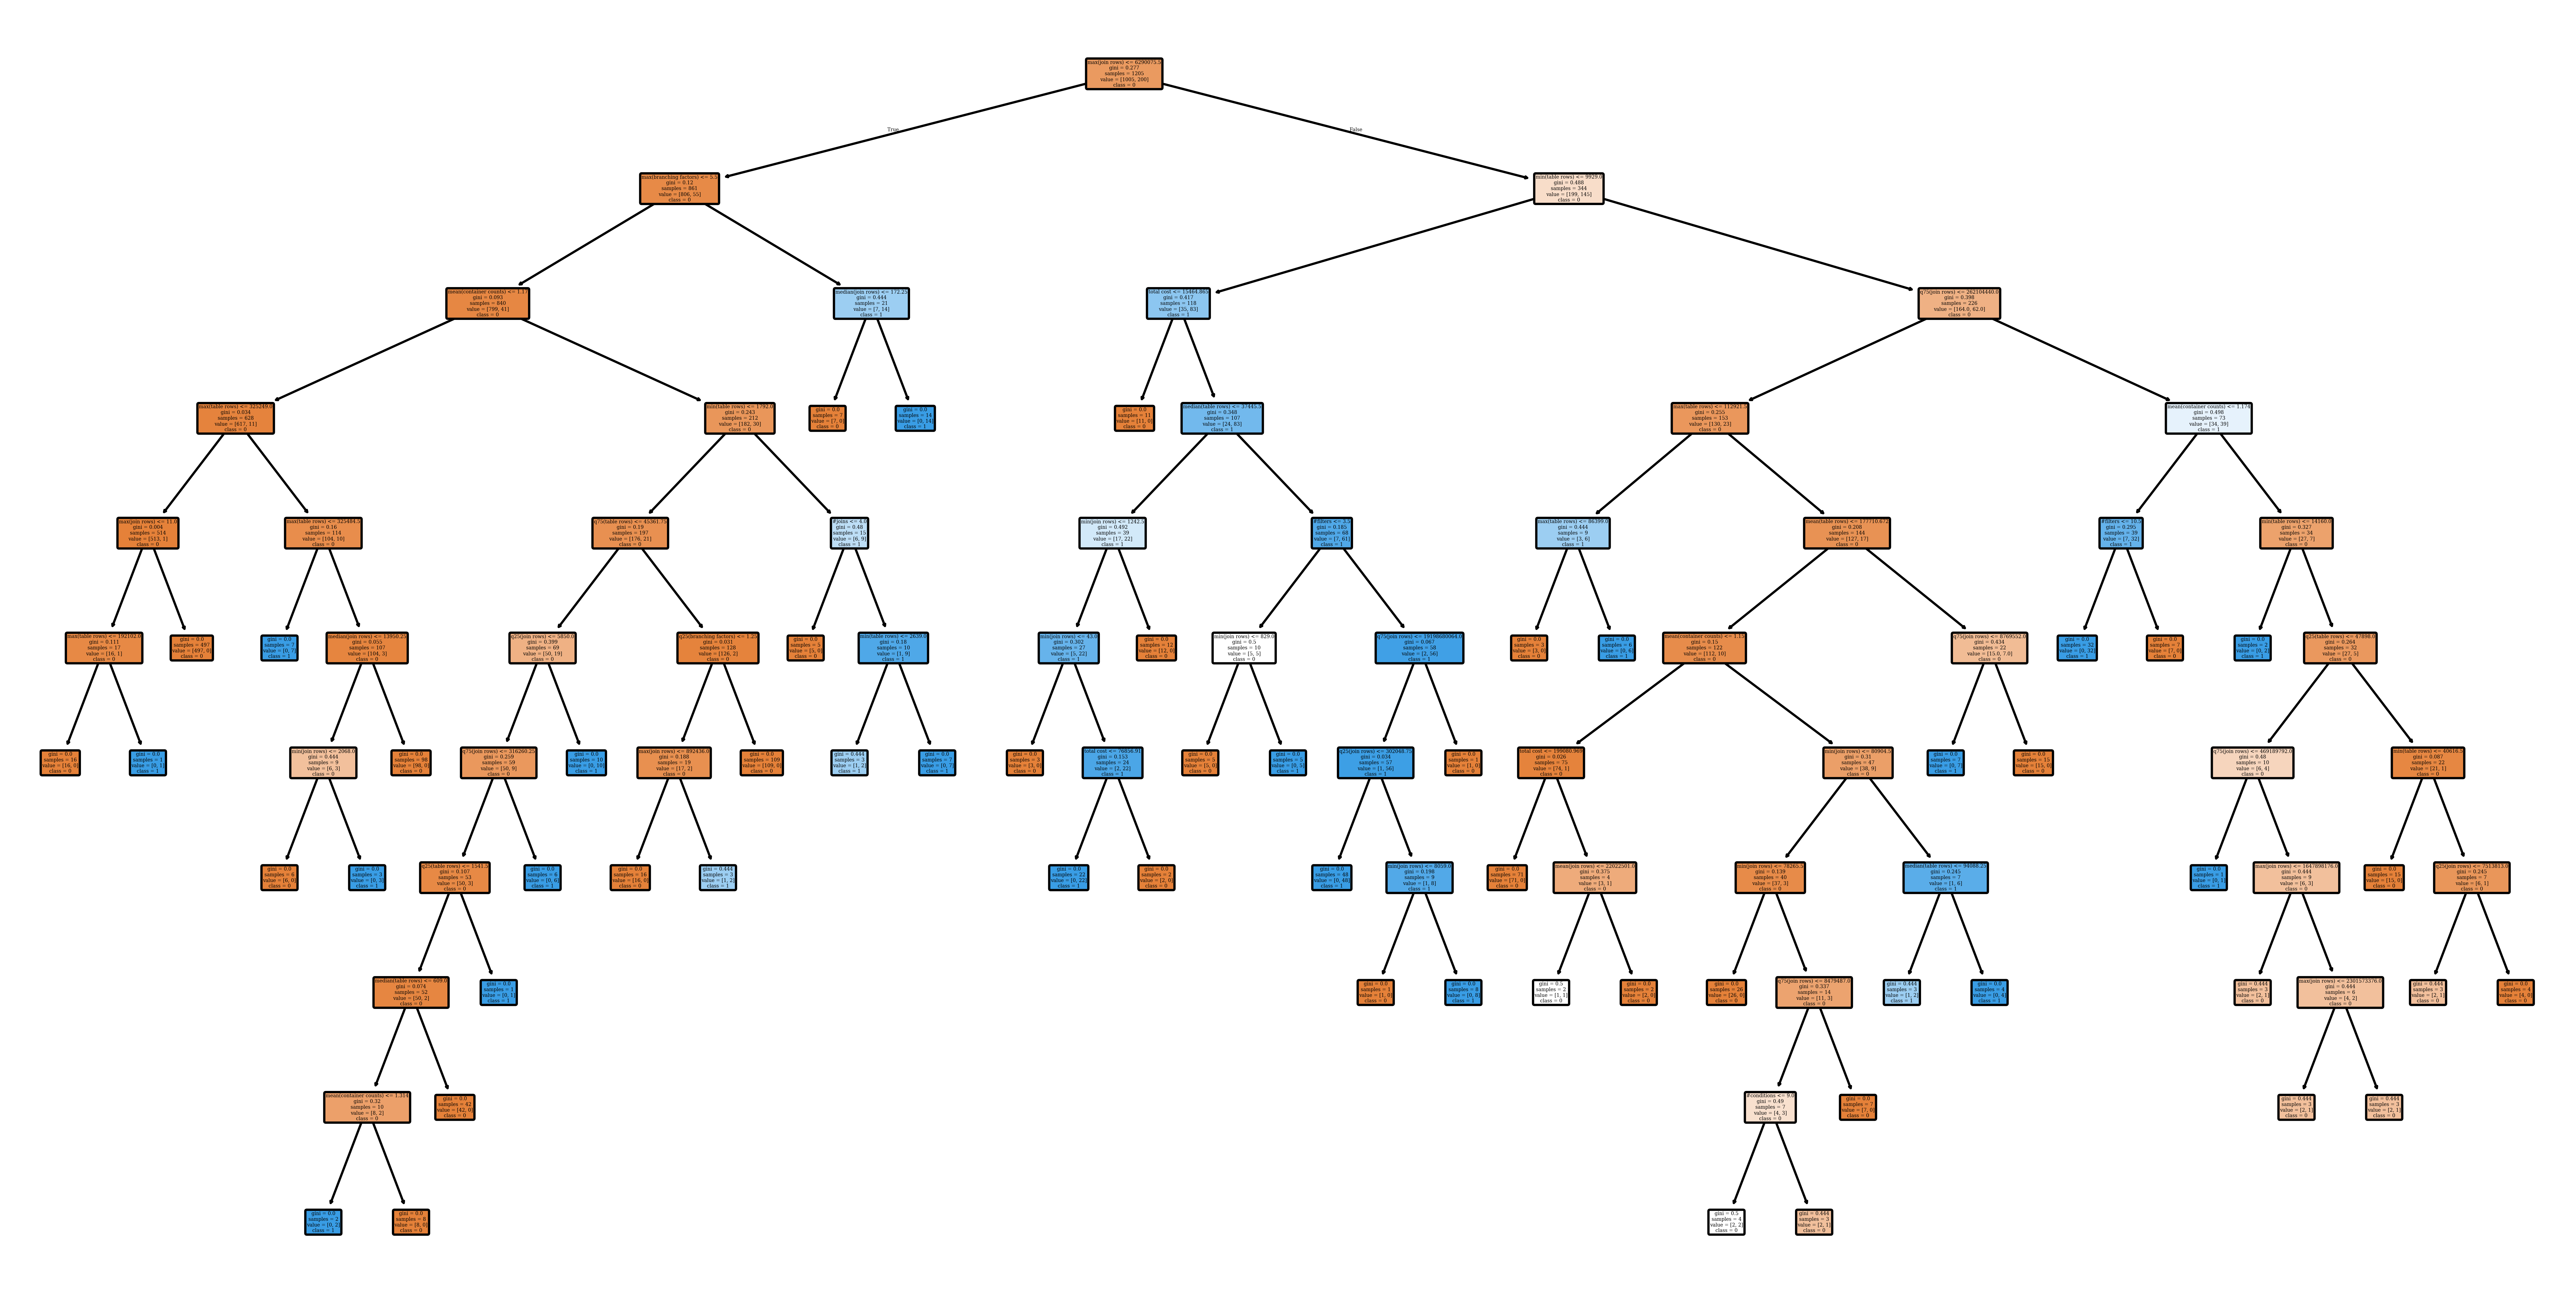

In [48]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/SPA_extra_enum_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_4271/129295257.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_4271/129295257.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_4271/129295257.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

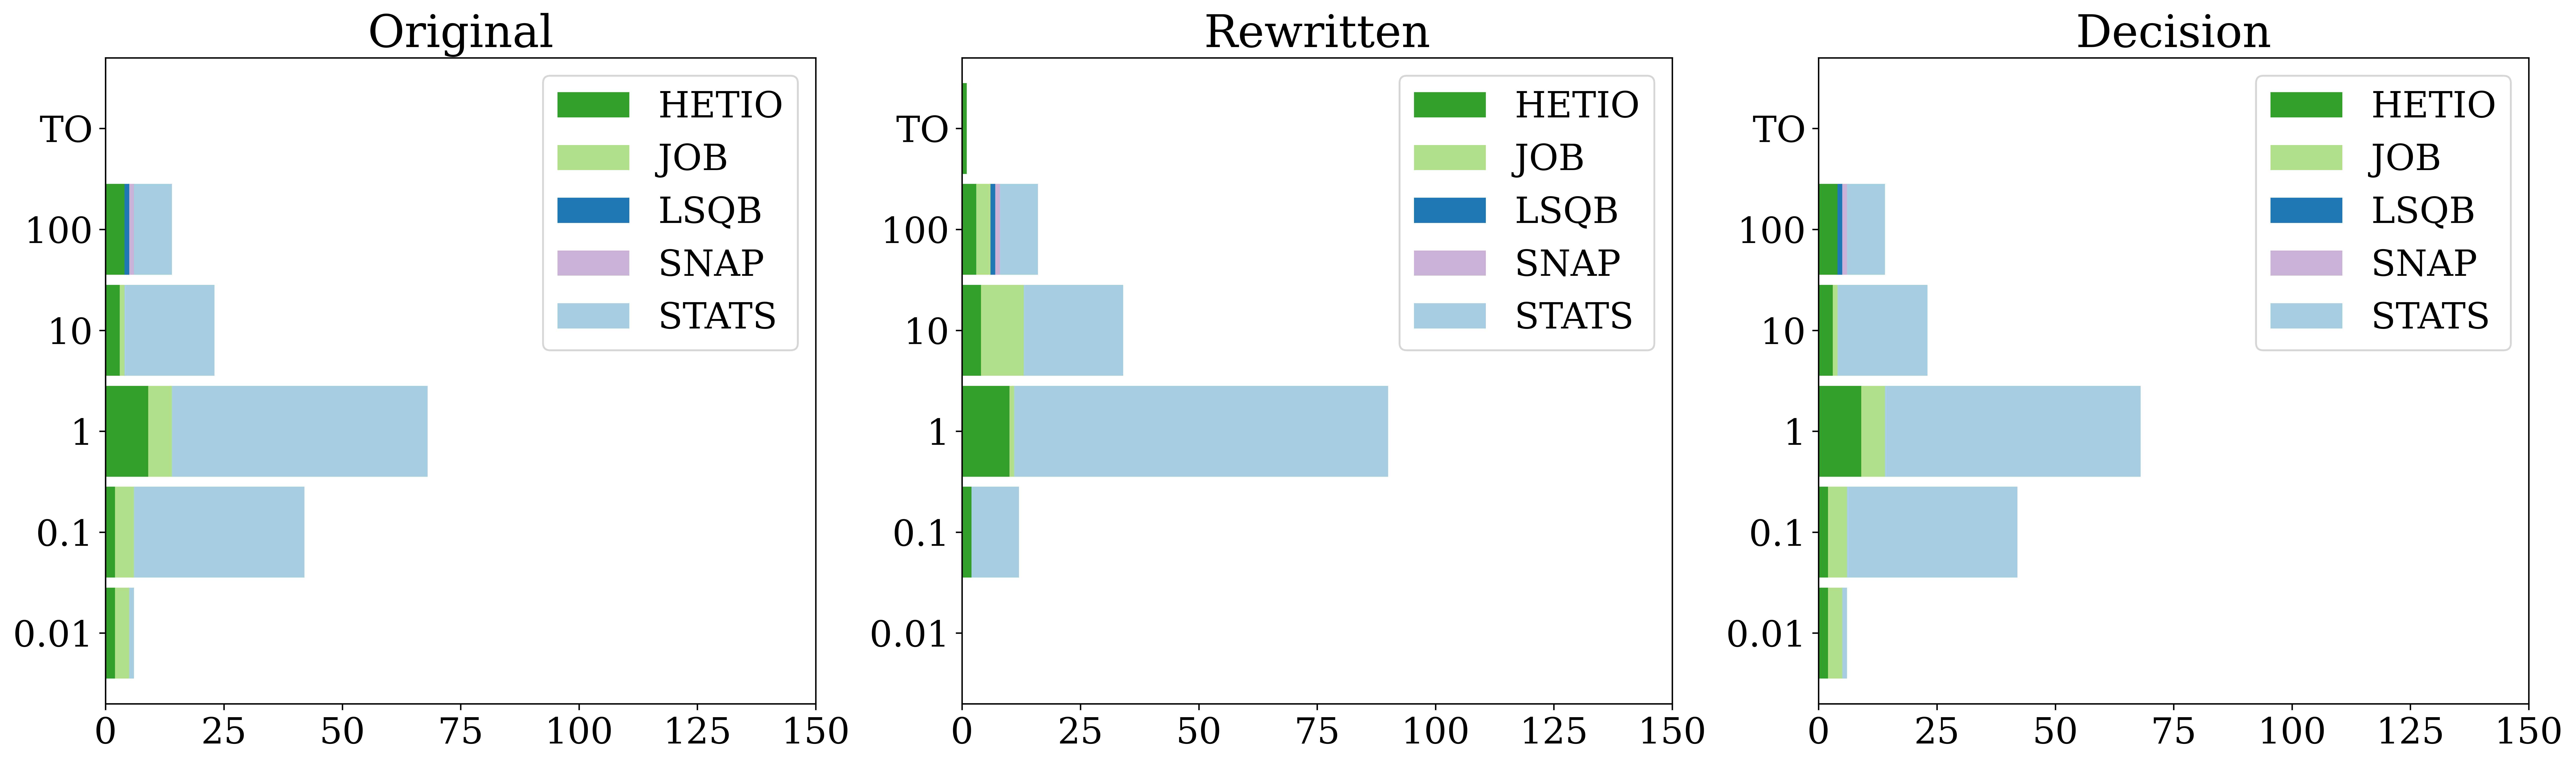

In [49]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 150

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_extra_enum_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_4271/2011856665.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_4271/2011856665.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_4271/2011856665.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warni

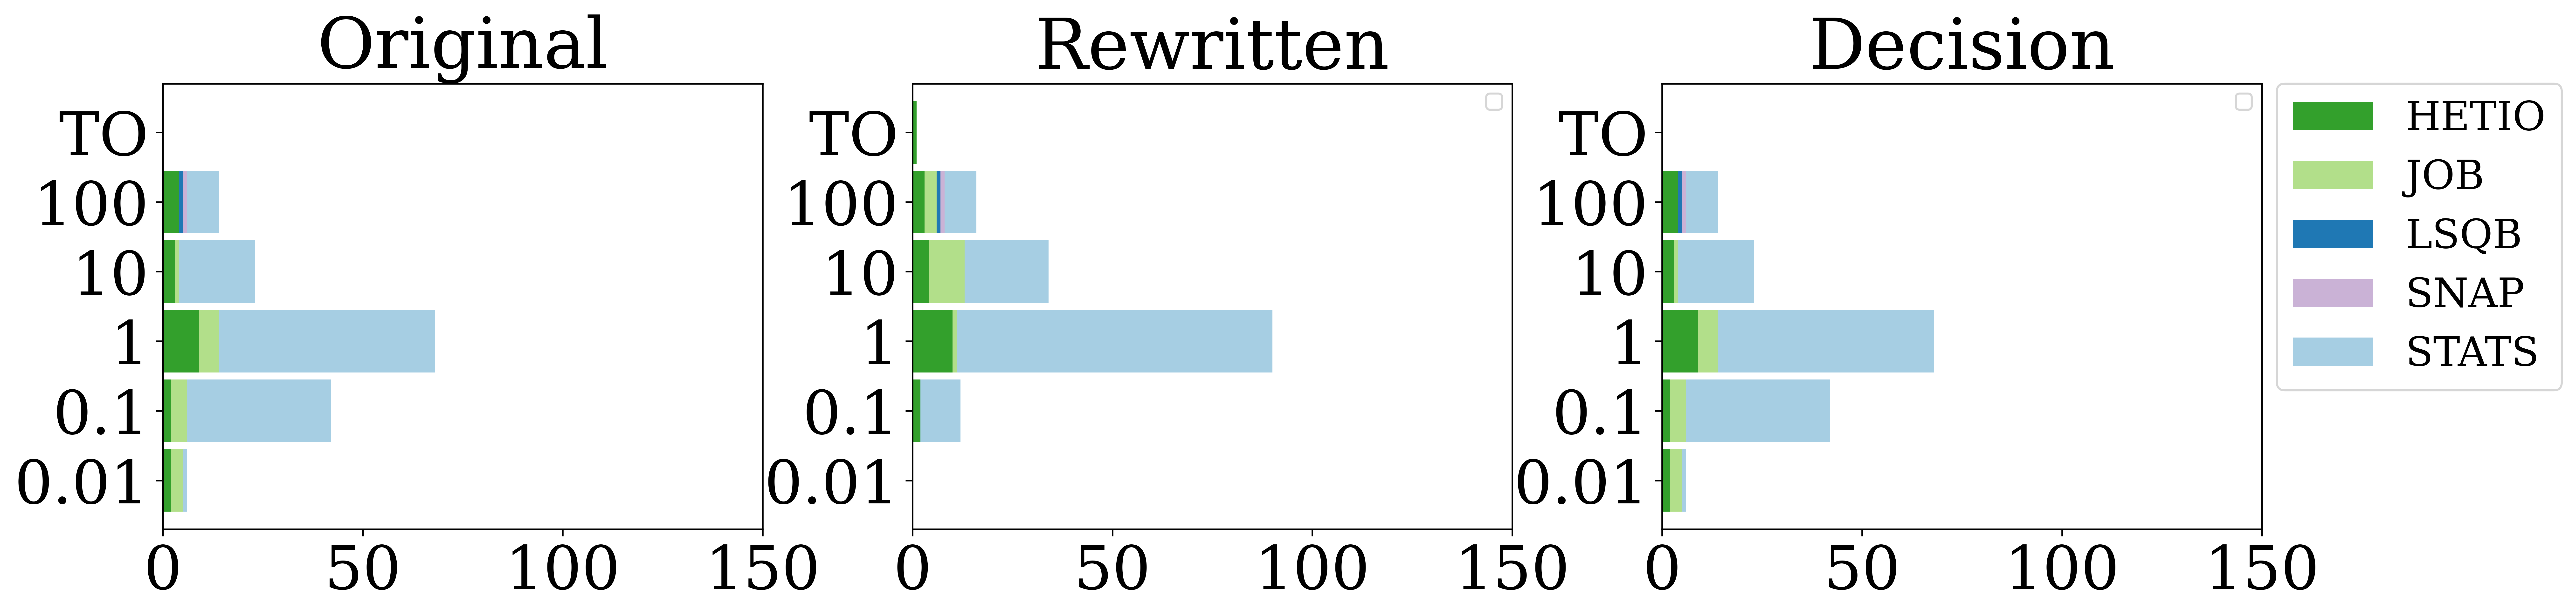

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 150

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/SPA_extra_enum_runtimes_color.png') 
plt.show()


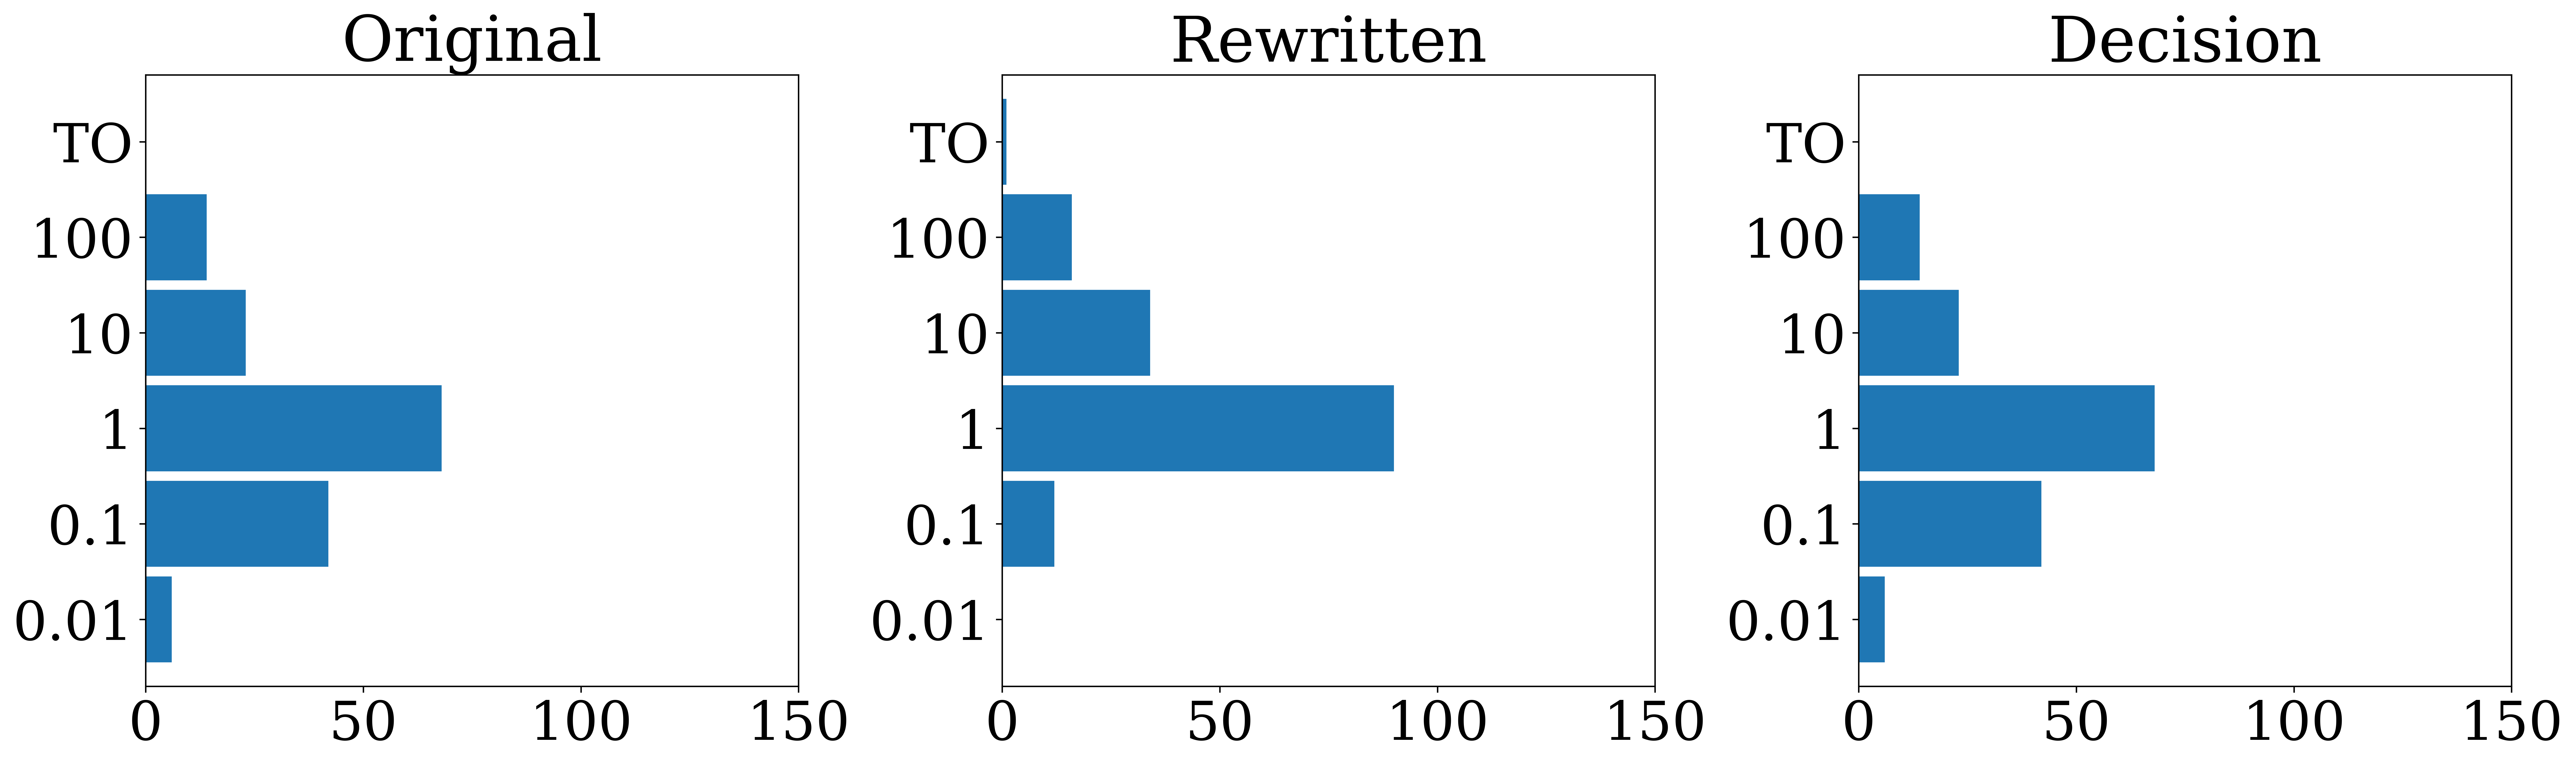

In [51]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 150

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_extra_enum_runtimes.png')
plt.show()